In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime

In [3]:
def assessment(data, y_feature, x_feature, index=-1):
    """
    Visualization function to show histograms and scatter plots.
    """
    for row in data:
        if index >= 0:
            color = np.where(data[row].index == index,'r','g')
            hue = None
        else:
            color = 'b'
            hue = None
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    chart1 = sns.histplot(data[x_feature], ax=axes[0], kde=False, color='g')
    chart1.set_xlabel(x_feature, fontsize=10)
    if index >= 0:
        chart2 = plt.scatter(data[x_feature], data[y_feature], c=color, edgecolors='w')
        chart2 = plt.xlabel(x_feature, fontsize=10)
        chart2 = plt.ylabel(y_feature, fontsize=10)
    else:
        chart2 = sns.scatterplot(x=x_feature, y=y_feature, data=data, hue=hue, legend=False)
        chart2.set_xlabel(x_feature,fontsize=10)
        chart2.set_ylabel(y_feature,fontsize=10)
    plt.show()

In [5]:
def correlation_map(data, feature, number):
    """
    Develops a heatmap showing correlations.
    """
    most_correlated = data.corr().nlargest(number, feature)[feature].index
    correlation = data[most_correlated].corr()

    mask = np.zeros_like(correlation)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        fig, axes = plt.subplots(figsize=(20, 10))
        sns.heatmap(
            correlation,
            mask=mask,
            vmin=-1,
            vmax=1,
            square=True,
            center=0,
            annot=True,
            annot_kws={"size": 8},
            cmap="PRGn",
        )
    plt.show()

In [7]:
# Load and preprocess the data
data = pd.read_csv("./dataset/smart_grid_stability_augmented.csv")
map1 = {"unstable": 0, "stable": 1}
data["stabf"] = data["stabf"].replace(map1)
data = data.sample(frac=1)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13292\1042916931.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["stabf"] = data["stabf"].replace(map1)


In [9]:
print(data.head())

           tau1      tau2      tau3      tau4        p1        p2        p3  \
35363  7.228485  6.130487  1.696129  9.153066  4.369614 -1.992499 -1.018796   
37286  2.952382  2.535562  0.551307  7.240984  3.160739 -1.586707 -0.635928   
33827  6.713878  3.528662  1.543185  2.561357  3.111843 -0.845011 -0.532246   
42616  0.712268  1.579796  5.776966  1.620336  3.152710 -0.515998 -1.230553   
24444  7.907289  6.752548  5.195423  6.694166  2.980842 -0.760323 -1.427854   

             p4        g1        g2        g3        g4      stab  stabf  
35363 -1.358319  0.160917  0.597125  0.807760  0.355351 -0.009640      1  
37286 -0.938105  0.327195  0.378635  0.840212  0.391699 -0.030519      1  
33827 -1.734586  0.573419  0.349372  0.067430  0.766504 -0.016590      1  
42616 -1.406159  0.286674  0.286268  0.621781  0.816981 -0.058378      1  
24444 -0.792665  0.937835  0.762719  0.962502  0.827174  0.109403      0  


In [11]:
X_dataframe = data.drop('stabf', axis=1)
y_dataframe = data['stabf']

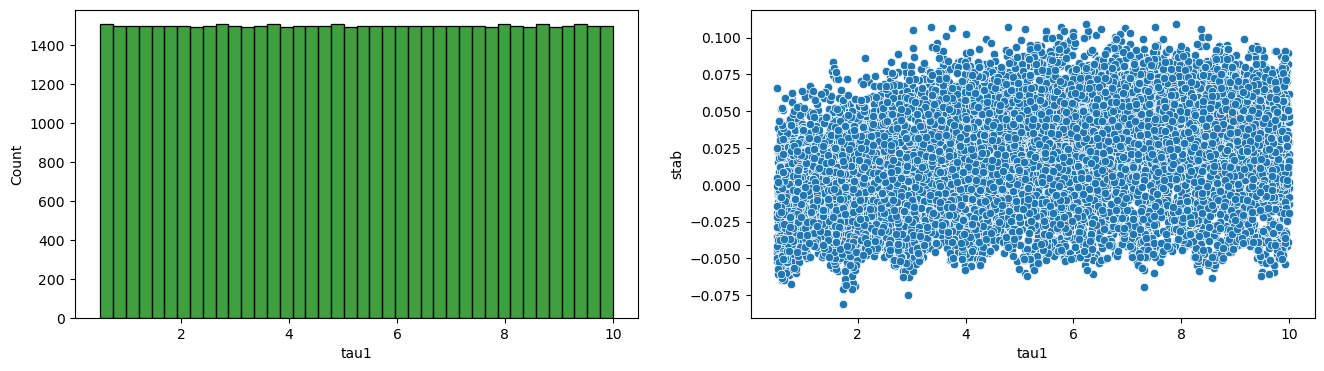

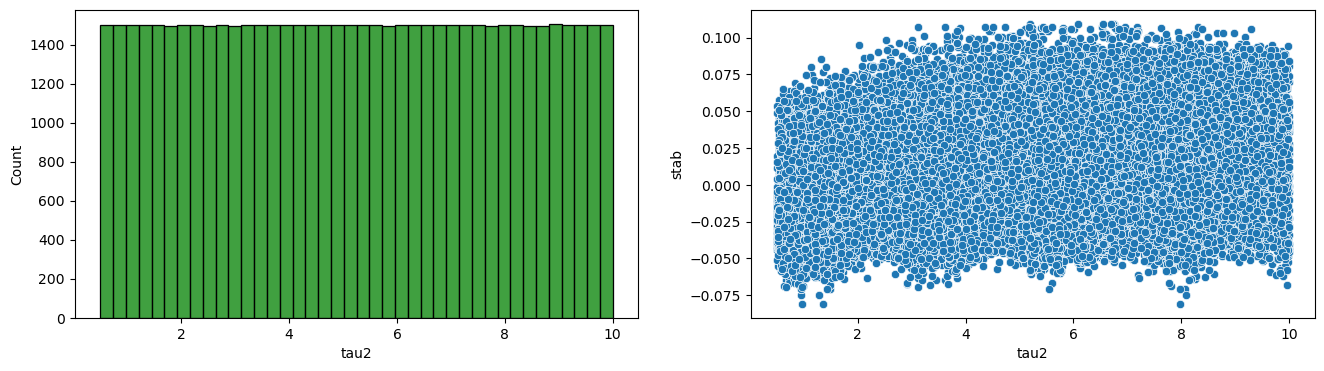

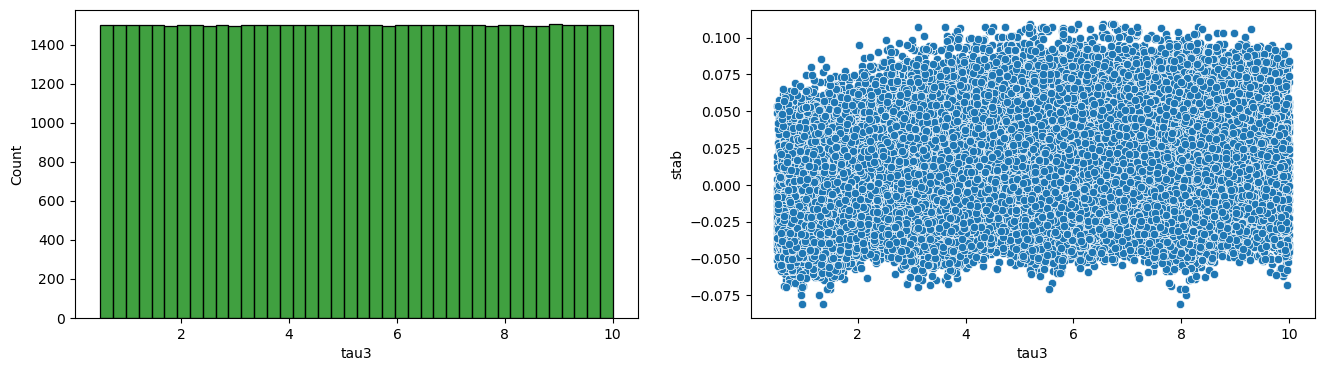

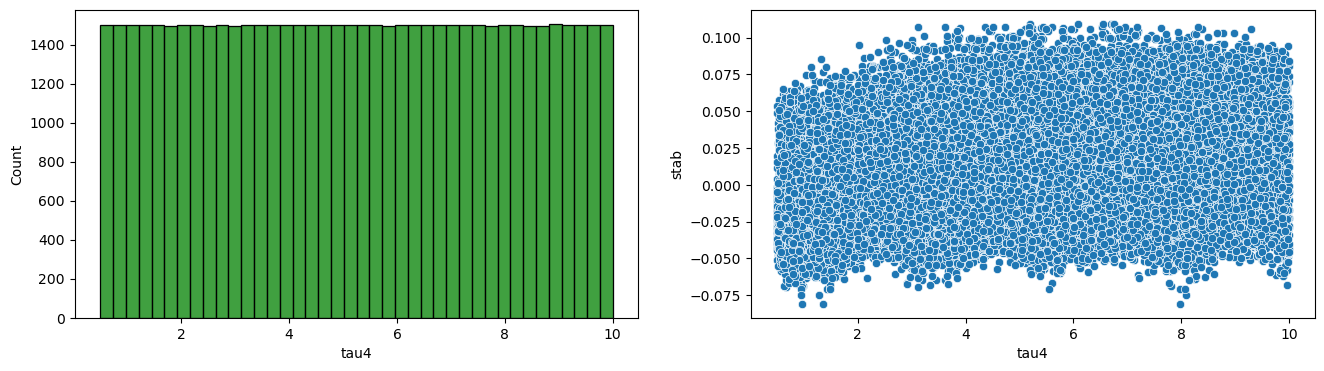

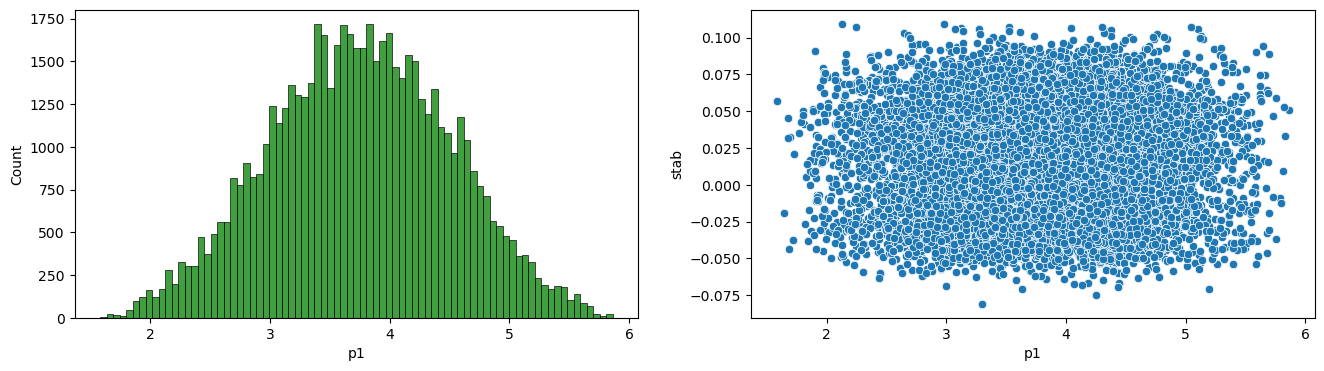

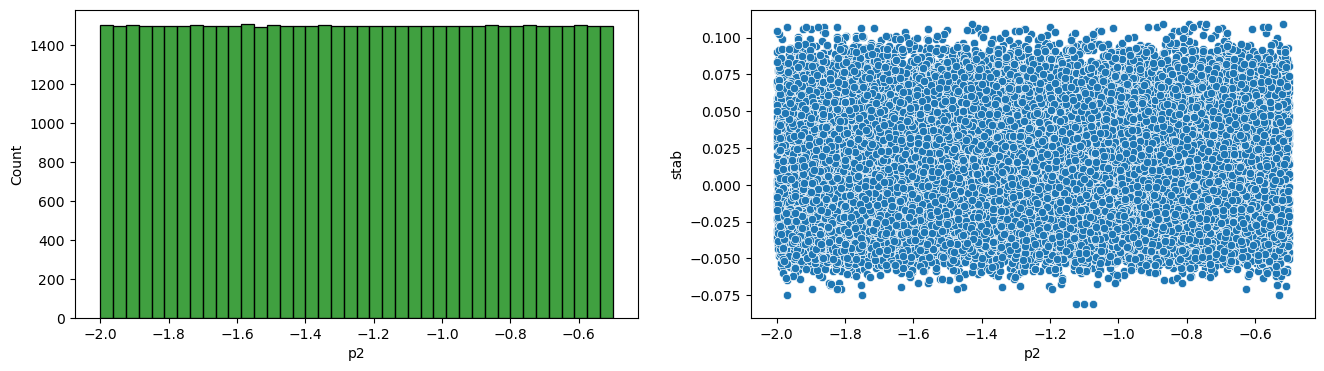

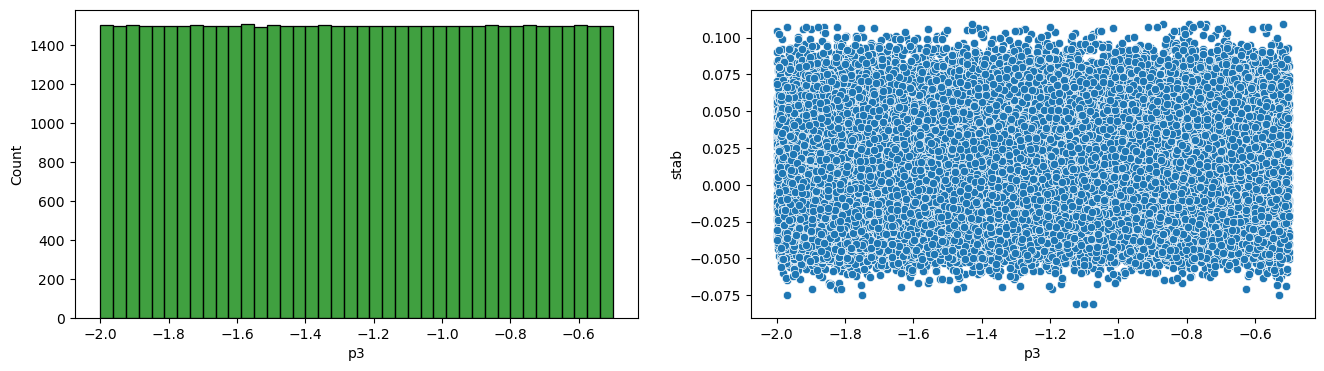

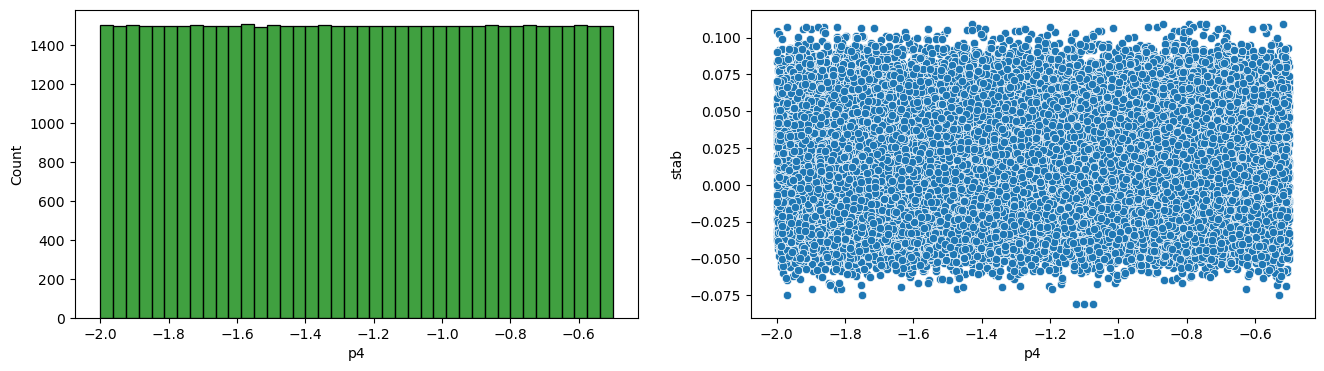

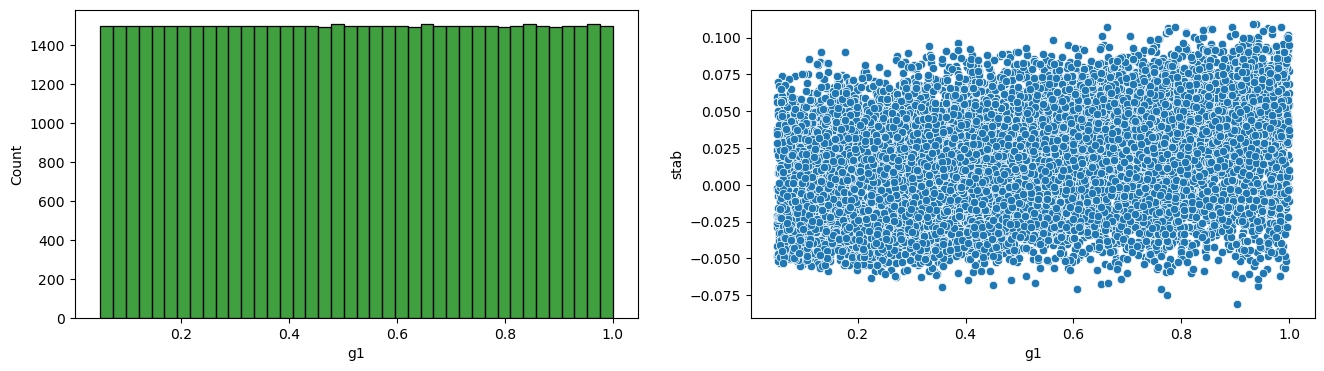

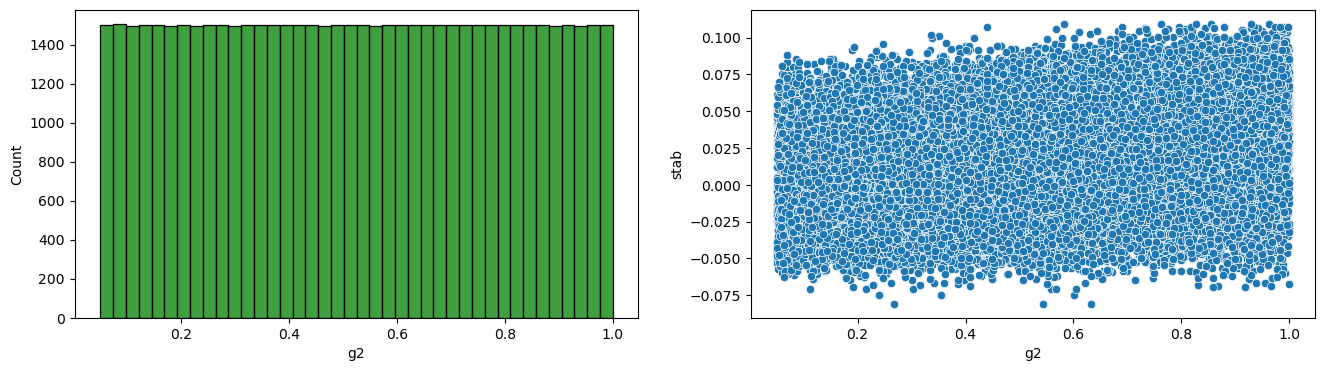

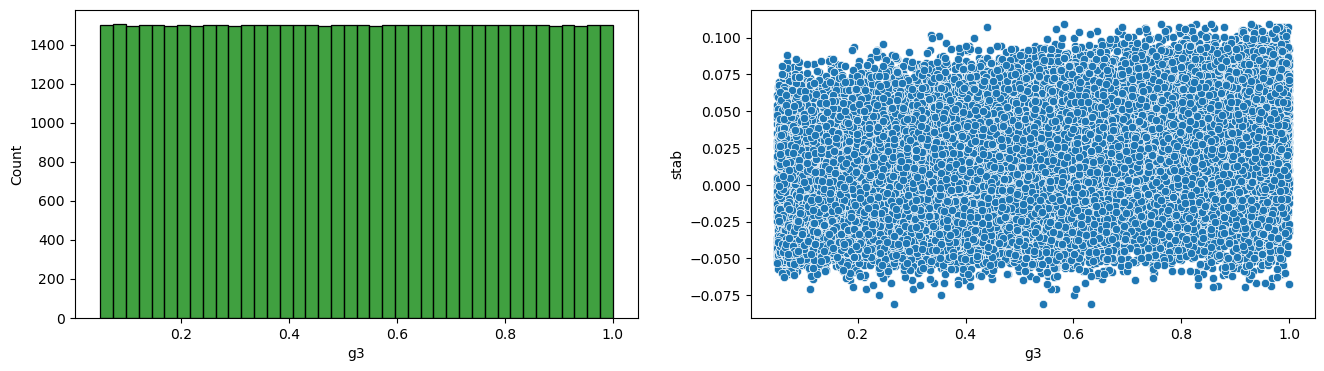

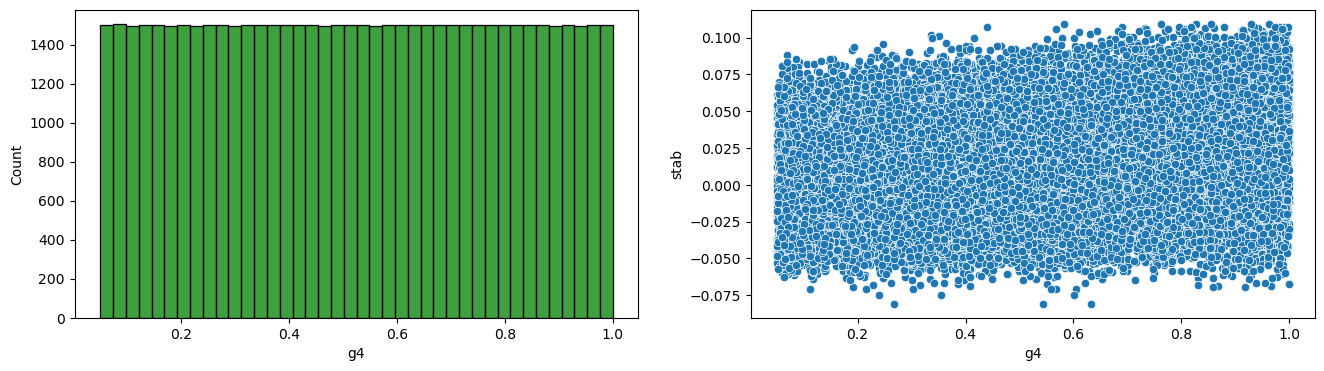

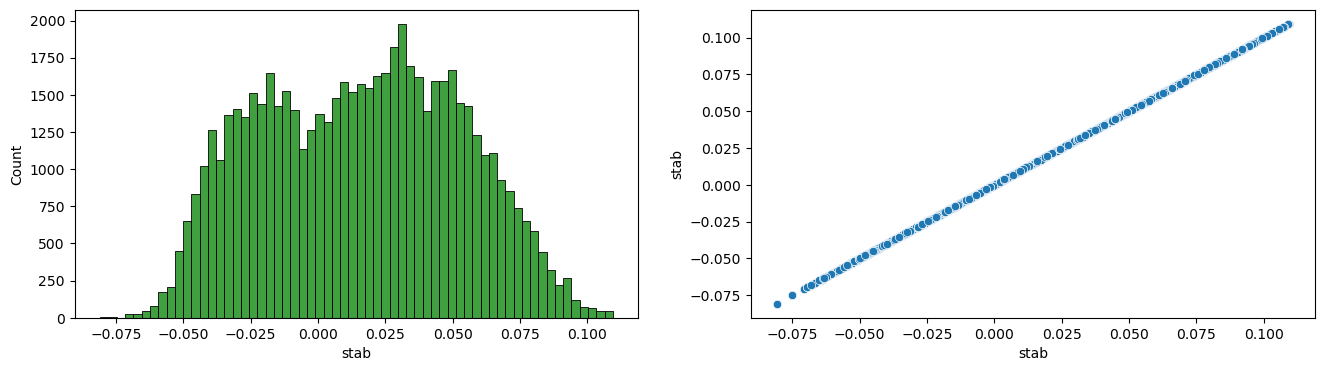

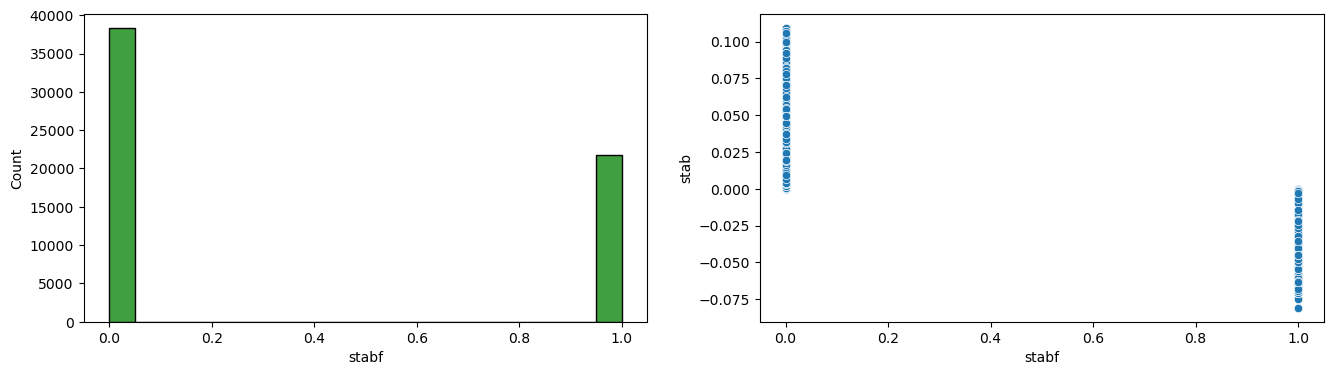

In [13]:
for col in data.columns:
    assessment(data, "stab", col, -1)

In [39]:
print(data.p1.skew())

-0.012688423269881649


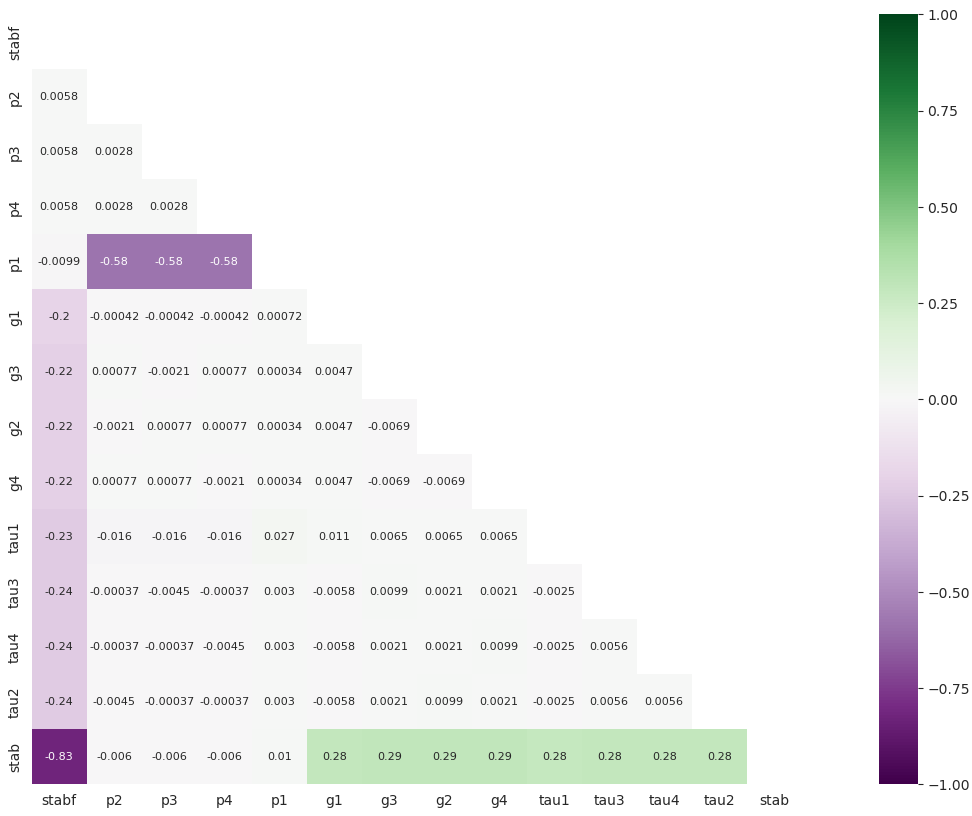

In [41]:
#Checking the correlation of the features
correlation_map(data, 'stabf', 14)

In [43]:
print('Spliting of Stable (0) and Unstable (1) observation in the dataset')
print(data['stabf'].value_counts(normalize=True))

Spliting of Stable (0) and Unstable (1) observation in the dataset
stabf
0    0.638
1    0.362
Name: proportion, dtype: float64


In [51]:
X = data.iloc[:, :12].values
y = data.iloc[:, 13].values

In [53]:
X_train, X_test = X[:54000], X[54000:]
y_train, y_test = y[:54000], y[54000:]

In [55]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [59]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(12, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 24)
        self.fc4 = nn.Linear(24, 1)
        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = self.elu(self.fc2(x))
        x = self.elu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

In [61]:
# Initialize the model, loss function, and optimizer
model = NeuralNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [71]:
# Cross-validation
kf = KFold(10, shuffle=True, random_state=10)
start_time = datetime.now()
print("Model evaluation\n")

Model evaluation



In [73]:
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    x_train, x_val = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val = y_train[train_idx], y_train[val_idx]
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train_fold)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs, y_val)
        val_accuracy = accuracy_score(y_val.numpy(), (val_outputs.numpy() > 0.5).astype(int))
        print(f"Fold {fold + 1} - Loss: {val_loss:.4f} | Accuracy: {val_accuracy * 100:.2f}%")

Fold 1 - Loss: 0.0221 | Accuracy: 99.22%
Fold 2 - Loss: 0.0196 | Accuracy: 99.31%
Fold 3 - Loss: 0.0159 | Accuracy: 99.41%
Fold 4 - Loss: 0.0378 | Accuracy: 99.39%
Fold 5 - Loss: 0.0158 | Accuracy: 99.37%
Fold 6 - Loss: 0.0223 | Accuracy: 99.39%
Fold 7 - Loss: 0.0172 | Accuracy: 99.43%
Fold 8 - Loss: 0.0128 | Accuracy: 99.54%
Fold 9 - Loss: 0.0300 | Accuracy: 99.61%
Fold 10 - Loss: 0.0164 | Accuracy: 99.41%


In [75]:
# Test the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = (y_pred.numpy() > 0.5).astype(int)
    cm = confusion_matrix(y_test.numpy(), y_pred)
    test_accuracy = accuracy_score(y_test.numpy(), y_pred)

print(f"\nConfusion Matrix:\n{cm}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

end_time = datetime.now()
print("\nStart time", start_time)
print("End time", end_time)
print("Time elapsed", end_time - start_time)


Confusion Matrix:
[[3805   45]
 [  46 2104]]
Test Accuracy: 98.48%

Start time 2025-02-19 23:28:13.807821
End time 2025-02-19 23:30:05.792042
Time elapsed 0:01:51.984221


In [77]:
cm = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels=[0, 1]),
                  index=["Actual Unstable", "Actual Stable"],
                  columns=["Predicted Unstable", "Predicted Stable"])
print(cm)

                 Predicted Unstable  Predicted Stable
Actual Unstable                3805                45
Actual Stable                    46              2104


In [79]:
print(f'Accuracy per the confusion matrix: {((cm.iloc[0, 0] + cm.iloc[1, 1]) / len(y_test) * 100):.2f}%')

Accuracy per the confusion matrix: 98.48%


In [81]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3850
         1.0       0.98      0.98      0.98      2150

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000

